## Project Goal
- Task: Binary segmentation of fingernails in images

- Approach: U-Net (2 classes: background / nail)

In [32]:
import os, random, itertools, math, pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models 
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


In [33]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.16.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data & Preprocessing

- load the data

- creating datasets X and Y

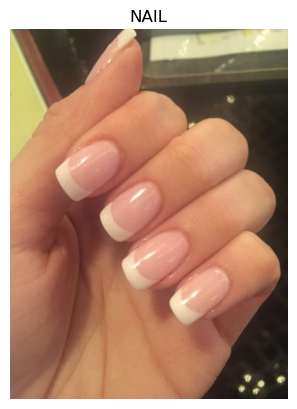

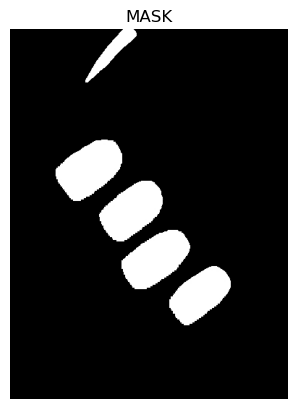

(512, 384, 3)


In [34]:
img_path_image = "/Users/mitkovasltchev/Documents/06 Arbeit/03 Portfolio/Nails_Segmentation/Data/images/1eecab90-1a92-43a7-b952-0204384e1fae.jpg"
img_path_mask = "/Users/mitkovasltchev/Documents/06 Arbeit/03 Portfolio/Nails_Segmentation/Data/labels/1eecab90-1a92-43a7-b952-0204384e1fae.jpg"
img_image = Image.open(img_path_image)
img_mask = Image.open(img_path_mask)


img_image_arr = np.array(img_image)
img_mask_arr = np.array(img_mask)
plt.imshow(img_image_arr, cmap = "gray")
plt.axis("off")
plt.title("NAIL")
plt.show()

plt.imshow(img_mask_arr, cmap = "gray")
plt.axis("off")
plt.title("MASK")
plt.show()

print(img_image_arr.shape)


['09aefeec-e05f-11e8-87a6-0242ac1c0002.jpg', '1eecab90-1a92-43a7-b952-0204384e1fae.jpg', '2C29D473-CCB4-458C-926B-99D0042161E6.jpg', '2c376c66-9823-4874-869e-1e7f5c54ec7b.jpg', '34404E67-4BB8-432E-863E-C1BEF5EB37E0.jpg', '3493127D-7B19-4E50-94AE-2401BD2A91C8.jpg', '41d83dbb-7c39-4d91-979e-eec5ff71b265.jpg', '4252e46c-e40f-4543-91ab-031917d46c5c.jpg', '4c46b91a-e402-11e8-97db-0242ac1c0002.jpg', '4c472e18-e402-11e8-97db-0242ac1c0002.jpg', '4c478f3e-e402-11e8-97db-0242ac1c0002.jpg', '4c47ee66-e402-11e8-97db-0242ac1c0002.jpg', '4c484f8c-e402-11e8-97db-0242ac1c0002.jpg', '4c48acb6-e402-11e8-97db-0242ac1c0002.jpg', '4c490eae-e402-11e8-97db-0242ac1c0002.jpg', '4c49b502-e402-11e8-97db-0242ac1c0002.jpg', '4c4a0dd6-e402-11e8-97db-0242ac1c0002.jpg', '4c4a6402-e402-11e8-97db-0242ac1c0002.jpg', '54108996-6DA8-48F9-93DF-7ABB92F64E03.jpg', '5CBCC5AC-B638-4DFA-AA7B-2464FADFF2F7.jpg', '5fad3947-76d7-4352-9329-4a92f898dd59.jpg', '7e9f5818-4425-4d8a-808a-4673d96fa250.jpg', '865a1e90-7ad2-4ceb-b2a1-50b078

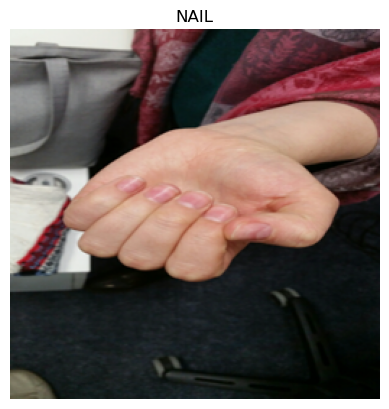

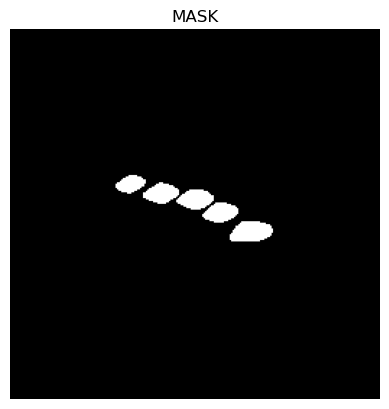

In [35]:
DATA_ROOT = "/Users/mitkovasltchev/Documents/06 Arbeit/03 Portfolio/Nails_Segmentation/Data"
IMAGES_DIR = os.path.join(DATA_ROOT, 'images')
MASKS_DIR = os.path.join(DATA_ROOT, 'labels' )


IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3   # set to 1 if your images are grayscale

image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(".jpg")]
image_files.sort()
print(image_files)

X = []
Y = []

for fname in image_files:
    # Images
    img_path = os.path.join(IMAGES_DIR, fname)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_arr = np.array(img)

    #Masks 
    mask_path = os.path.join(MASKS_DIR, fname)
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
    mask_arr = np.array(mask)

    mask_bin = (mask_arr > 0).astype(np.uint8)

    X.append(img_arr)
    Y.append(mask_bin)

X = np.array(X)
Y = np.array(Y)

#Normalize the data

X = X.astype("float32") / 255.0
Y = Y.astype("int32")
Y = np.expand_dims(Y, axis=-1)

print(X.shape)
print(Y.shape)


#visualizing a label-mask pair 

img_count = 30

plt.imshow(X[img_count], cmap = "gray")
plt.axis("off")
plt.title("NAIL")
plt.show()

plt.imshow(Y[img_count], cmap = "gray")
plt.axis("off")
plt.title("MASK")
plt.show()


## Train/ Val / Test Split

- Split: 70% train, 15% val, 15% test via train_test_split

In [ ]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


## Data Augmentation 

- Data augmentation increases training data variety (flips, rotations, etc.), which helps the model generalize better and reduces overfitting
- only applied on the training data
- basic horizintal flips and vertical flips 

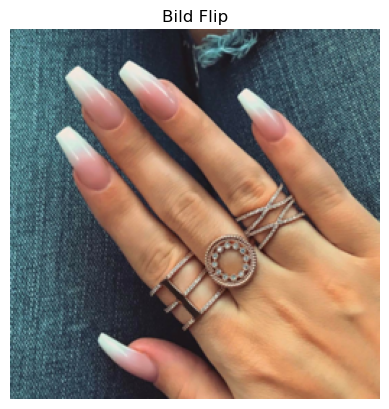

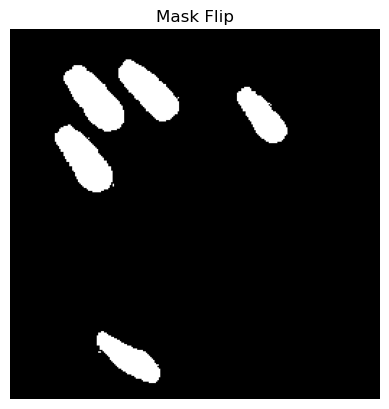

In [28]:
img = X_train[0]
mask = Y_train[0]

img_flipped = np.fliplr(img)
mask_flipped = np.fliplr(mask)

#Plot

plt.imshow(img_flipped)
plt.title("Bild Flip")
plt.axis("off")
plt.show()

plt.imshow(mask_flipped.squeeze(), cmap="gray")
plt.title("Mask Flip"); plt.axis("off")
plt.show()


# X_train: (N, 256, 256, 3)
# Y_train: (N, 256, 256, 1) oder (N, 256, 256)

# Horizontal flip (left ↔ right)
X_flip = np.flip(X_train, axis=2)   
Y_flip = np.flip(Y_train, axis=2)

# Vertical flips
X_flip_ud = np.flip(X_train, axis=1)
Y_flip_ud = np.flip(Y_train, axis=1)

# Combining original data and flipped data 
X_train_aug = np.concatenate([X_train, X_flip, X_flip_ud], axis=0)
Y_train_aug = np.concatenate([Y_train, Y_flip, Y_flip_ud], axis=0)




## Define Loss Function

- dice loss as loss function for training the model

In [ ]:
def dice_loss_tf(y_true, y_pred, smooth=1e-6):

    #y_true -> (B, H, W, 1)
    #y_pred -> (B, H, W, 2)
    y_true_s = tf.squeeze(y_true, axis = -1) # -> (B, H, W)
    y_pred_s = y_pred[..., 1]# -> (B, H, W) & take just the foreground value (probability of the pixel being 1)
    
    # y_true.shape = (8, 256, 256)
    # y_pred.shape = (8, 256, 256)


    y_true_s = tf.cast(y_true_s, tf.float32)
    y_pred_s = tf.cast(y_pred_s, tf.float32)

    #Flatten each image and keep batch dimension
    y_true_flat = tf.reshape(y_true_s, (tf.shape(y_true)[0],-1))
    y_pred_flat = tf.reshape(y_pred_s, (tf.shape(y_true)[0],-1))

    #Calculation
    dice_num = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
    dice_denom = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(y_pred_flat, axis=1)

    #calculate the dice score
    dice_scores = (2.0 * dice_num + smooth) / (dice_denom + smooth)
   
    mean_dice_score = tf.reduce_mean(dice_scores)

    return (1-mean_dice_score)



## Evaluation Metrics

- Dice coefficient and IOU

In [17]:
def iou_metric(y_true, y_pred):
    # y_true: (B,H,W,1)  0/1 mask
    # y_pred: (B,H,W,2)  softmax probabilities

    # prepare
    y_true_s = tf.cast(tf.squeeze(y_true, axis=-1), tf.float32)  # (B,H,W)
    y_true_s = tf.where(y_true_s > 0.5, 1.0, 0.0)
    y_pred_fg = tf.cast(y_pred[..., 1], tf.float32)                     # (B,H,W)

    intersection = tf.reduce_sum(y_true_s * y_pred_fg, axis=[1,2])
    union = tf.reduce_sum(y_true_s, axis=[1,2]) + \
            tf.reduce_sum(y_pred_fg, axis=[1,2]) - intersection

    iou = (intersection) / (union)
    return tf.reduce_mean(iou)


def dice_coefficient(y_true, y_pred):
    #y_true -> (B, H, W, 1)
    #y_pred -> (B, H, W, 2)
    y_true_s = tf.squeeze(y_true, axis = -1) # -> (B, H, W)
    y_pred_s = y_pred[..., 1]# -> (B, H, W) & take just the foreground value (probability of the pixel being 1)
    
    # y_true.shape = (8, 256, 256)
    # y_pred.shape = (8, 256, 256)

    #Ensure float dtype 
    y_true_s = tf.cast(y_true_s, tf.float32)
    y_pred_s = tf.cast(y_pred_s, tf.float32)

    #Flatten each image and keep batch dimension
    y_true_flat = tf.reshape(y_true_s, (tf.shape(y_true)[0],-1))
    y_pred_flat = tf.reshape(y_pred_s, (tf.shape(y_true)[0],-1))

    #Calculation
    dice_num = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
    dice_denom = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(y_pred_flat, axis=1)

    #calculate the dice score
    dice_scores = 2.0 * dice_num / dice_denom
    mean_dice_score = tf.reduce_mean(dice_scores)

    return mean_dice_score

## Define U-Net

In [18]:
def unet(input_shape=(256,256,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)
    b = layers.Conv2D(64, 3, activation="relu", padding="same")(b)

    # Decoder
    u3 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(b)
    u3 = layers.concatenate([u3, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u3)
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(c3)

    u4 = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u4 = layers.concatenate([u4, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u4)
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(c4)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c4)

    return models.Model(inputs, outputs)



## Model with dice loss

In [13]:
model_dice = unet(input_shape=(256,256,3), num_classes=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_dice.compile(optimizer=optimizer,
              loss=dice_loss_tf,
              metrics=[
                  "accuracy", dice_coefficient, iou_metric])

## Train the model 

In [19]:
history = model_dice.fit(
    X_train_aug, Y_train_aug,
    validation_data = (X_val, Y_val), 
    batch_size = 4,
    epochs = 200,
)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.0630 - dice_coefficient: 0.1060 - iou_metric: 0.0577 - loss: 0.8940 - val_accuracy: 0.0378 - val_dice_coefficient: 0.0694 - val_iou_metric: 0.0368 - val_loss: 0.9306
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.0521 - dice_coefficient: 0.0952 - iou_metric: 0.0516 - loss: 0.9048 - val_accuracy: 0.0378 - val_dice_coefficient: 0.0722 - val_iou_metric: 0.0384 - val_loss: 0.9278
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.0513 - dice_coefficient: 0.0994 - iou_metric: 0.0541 - loss: 0.9006 - val_accuracy: 0.0398 - val_dice_coefficient: 0.0750 - val_iou_metric: 0.0400 - val_loss: 0.9250
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.0636 - dice_coefficient: 0.1090 - iou_metric: 0.0600 - loss: 0.8910 - val_accuracy: 0.0953 - val_dice_coefficient: 0.0757 - val_iou_metric: 0.0403 - val_loss: 0.9243
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.1

## Evaluation

- Predictions: softmax → use foreground channel [..., 1]

- Test Dice: Numpy soft Dice averaged over test set; printed to console.

In [22]:
# Get model predictions
Y_pred = model_dice.predict(X_test)     # (B, 256, 256, 2)
Y_pred = Y_pred[..., 1]
Y_test_squeezed = Y_test.squeeze()

#Defining the Dice Score 

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice_scores = [dice_coef(Y_test_squeezed[i], Y_pred[i]) for i in range(len(Y_test))]


print("The Dice Score for the Test Images is: ", np.mean(dice_scores))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
The Dice Score for the Test Images is:  0.3824683883731571


## Visualization

### Learning curves: plots for Dice & IoU over epochs from history.history.

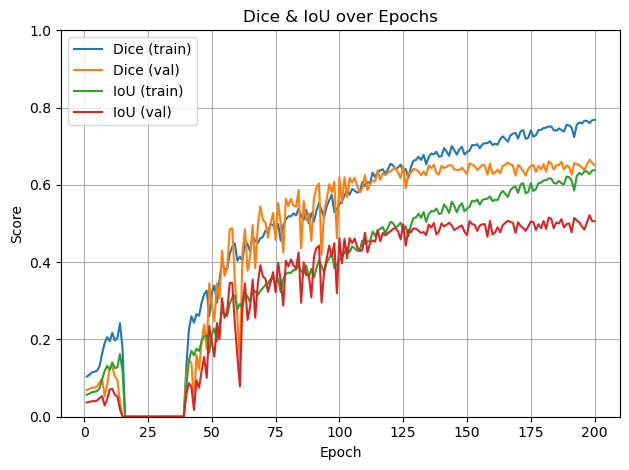

In [29]:
#Plotting Dice Score & IOU per Epoch for Training- and Validaton Data 

h = history.history
epochs = range(1, len(next(iter(h.values()))) + 1)

plt.figure()
if 'dice_coefficient' in h:       plt.plot(epochs, h['dice_coefficient'], label='Dice (train)')
if 'val_dice_coefficient' in h:   plt.plot(epochs, h['val_dice_coefficient'], label='Dice (val)')
if 'iou_metric' in h:        plt.plot(epochs, h['iou_metric'], label='IoU (train)')
if 'val_iou_metric' in h:    plt.plot(epochs, h['val_iou_metric'], label='IoU (val)')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Dice & IoU over Epochs')
plt.ylim(0, 1)  # typical for these metrics
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Qualitative examples: side-by-side input, ground truth, and prediction for samples from Train/Val/Test.

In [30]:
def show_predictions(model, X, Y, n=5):
 
    idxs = np.random.choice(len(X), n, replace=False)

    for idx in idxs:
        img = X[idx]
        true_mask = Y[idx]

        # Prediction
        pred = model.predict(np.expand_dims(img, 0), verbose=0)[0]
        pred_mask = np.argmax(pred, axis=-1)

        # Plot
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Bild")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(true_mask[:,:,0], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Vorhersage")
        plt.axis("off")

        plt.show()


Training Data

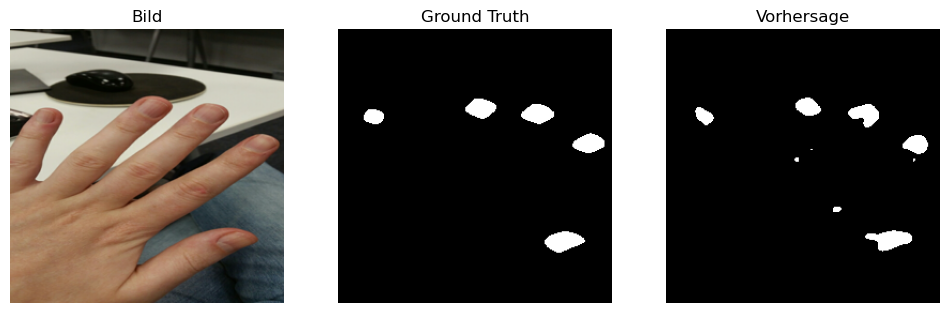

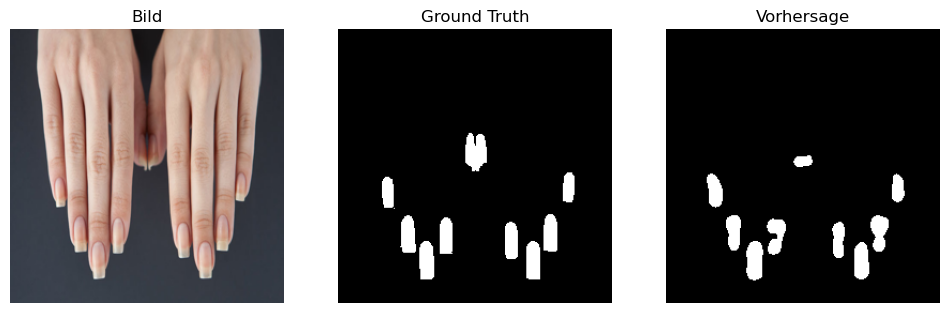

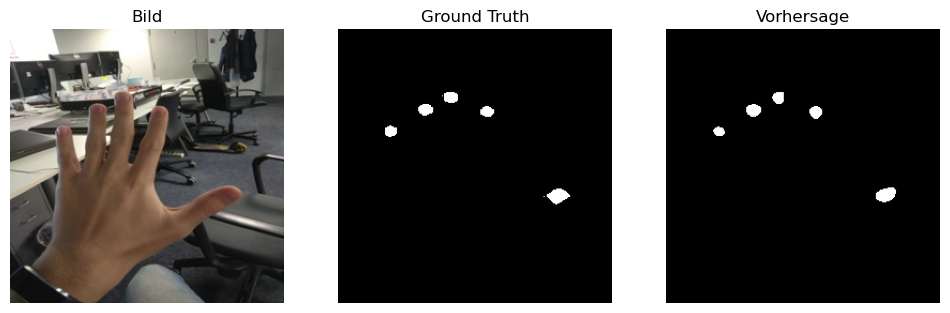

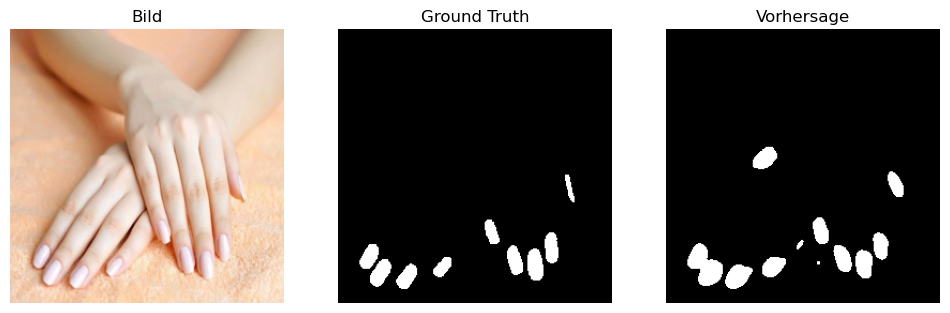

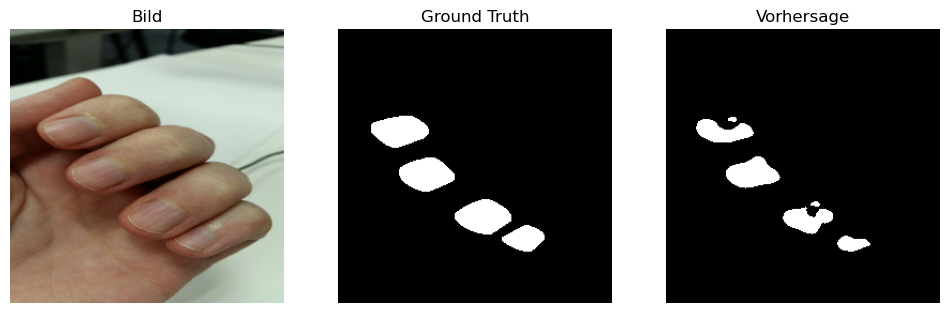

In [ ]:


show_predictions(model_dice, X_train, Y_train, n=5)

Validation Data

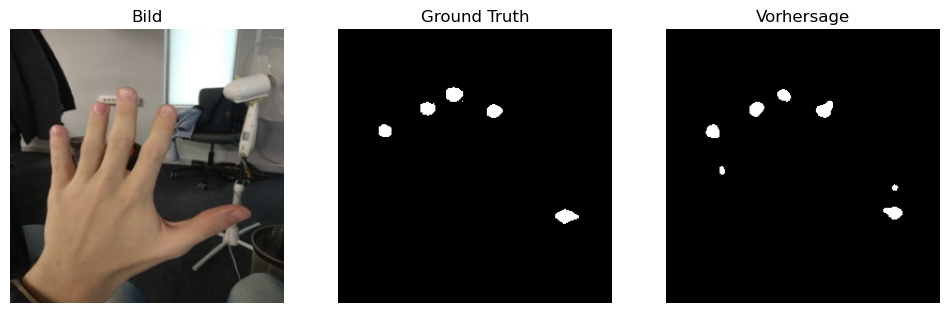

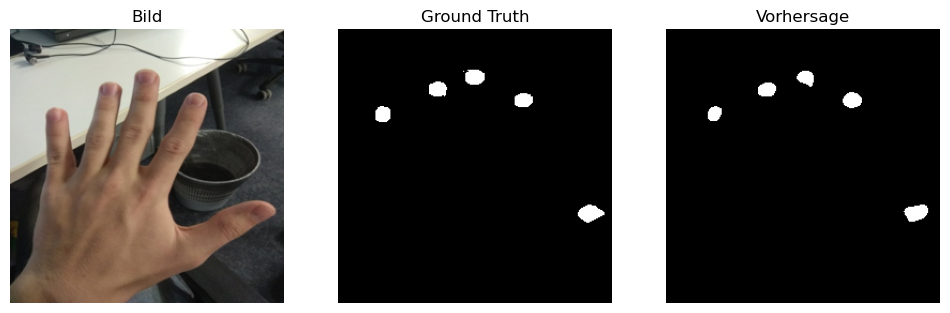

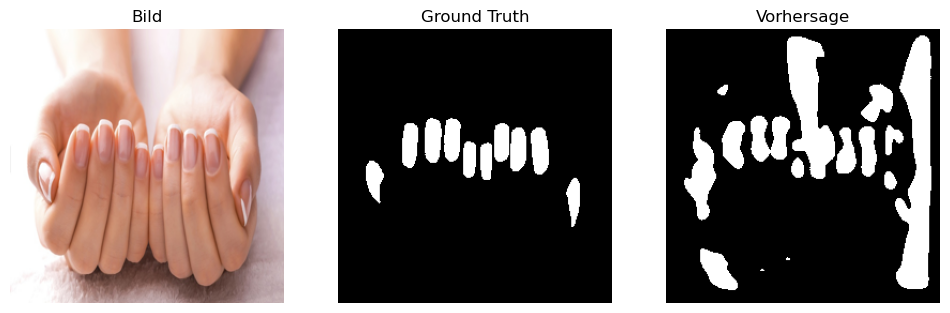

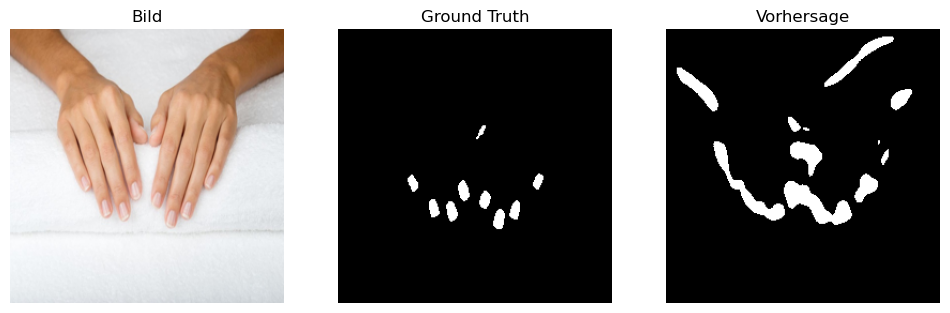

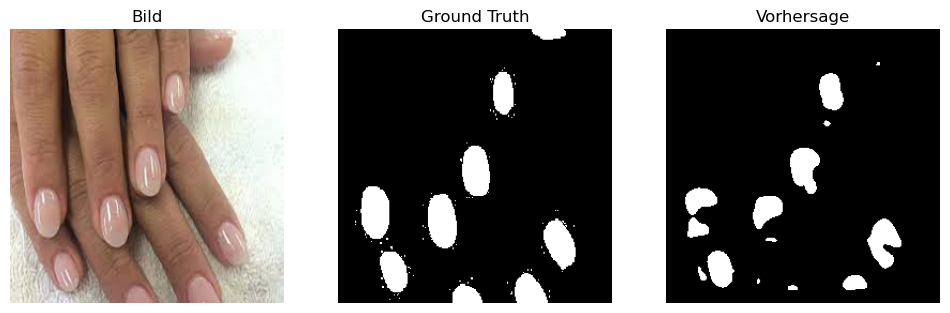

In [25]:
show_predictions(model_dice, X_val, Y_val, n=5)

Test Data

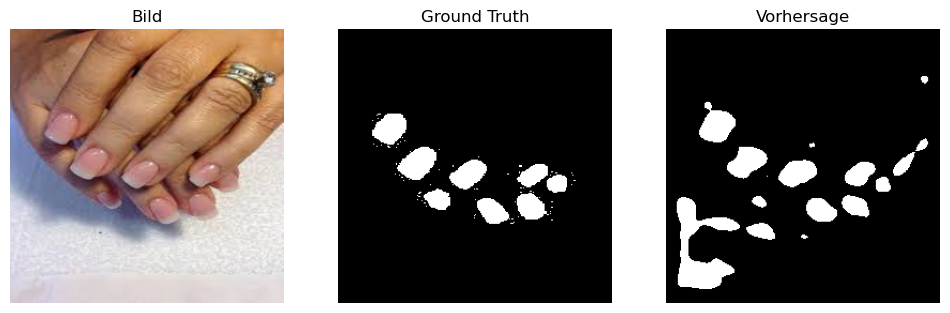

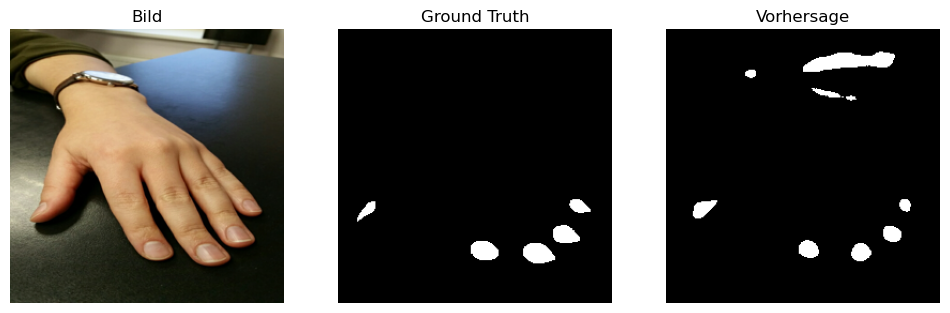

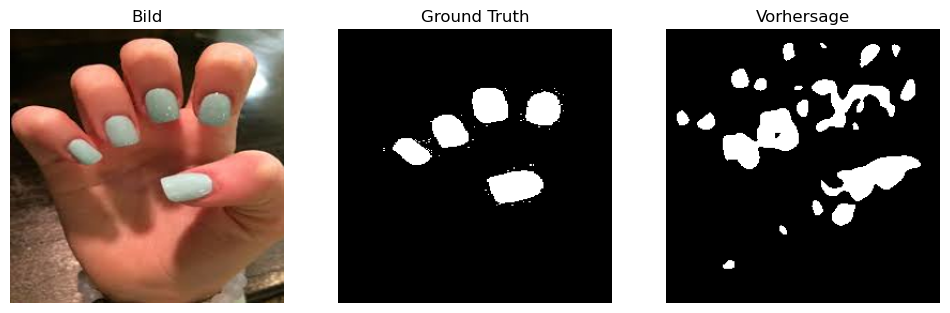

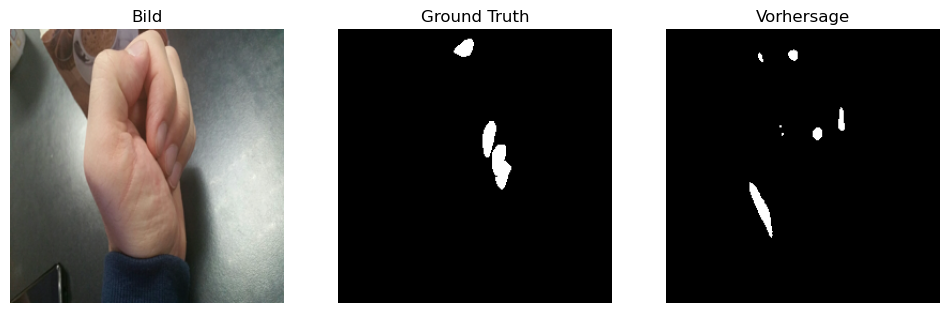

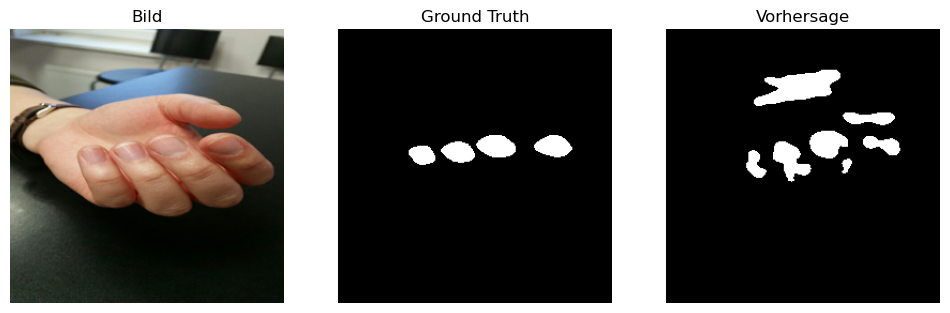

In [ ]:

show_predictions(model_dice, X_test, Y_test, n=5)